In [29]:
from rdflib import Graph, Namespace, URIRef, RDF, RDFS, OWL

# Namespaces
NELL = Namespace("http://nell-995.org/")
g = Graph()
g.bind("nell", NELL)
g.bind("owl", OWL)
g.bind("rdfs", RDFS)

# Define a generic entity class
g.add((NELL.Entity, RDF.type, OWL.Class))

# Helper function for URI cleaning
def clean_uri(text):
    return text.replace("concept:", "").replace(":", "_").replace("/", "_")

path = "kb_env_rl.txt"
i=0
with open(path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 3:
            subject, obj, relation = parts  # predicate = 3rd column
            s = URIRef(f"{NELL}{clean_uri(subject)}")
            p = URIRef(f"{NELL}{clean_uri(relation)}")
            o = URIRef(f"{NELL}{clean_uri(obj)}")

            # Add the triple itself
            g.add((s, p, o))

            # Add class and property semantics
            g.add((p, RDF.type, OWL.ObjectProperty))
            g.add((s, RDF.type, NELL.Entity))
            g.add((o, RDF.type, NELL.Entity))
            i+=1

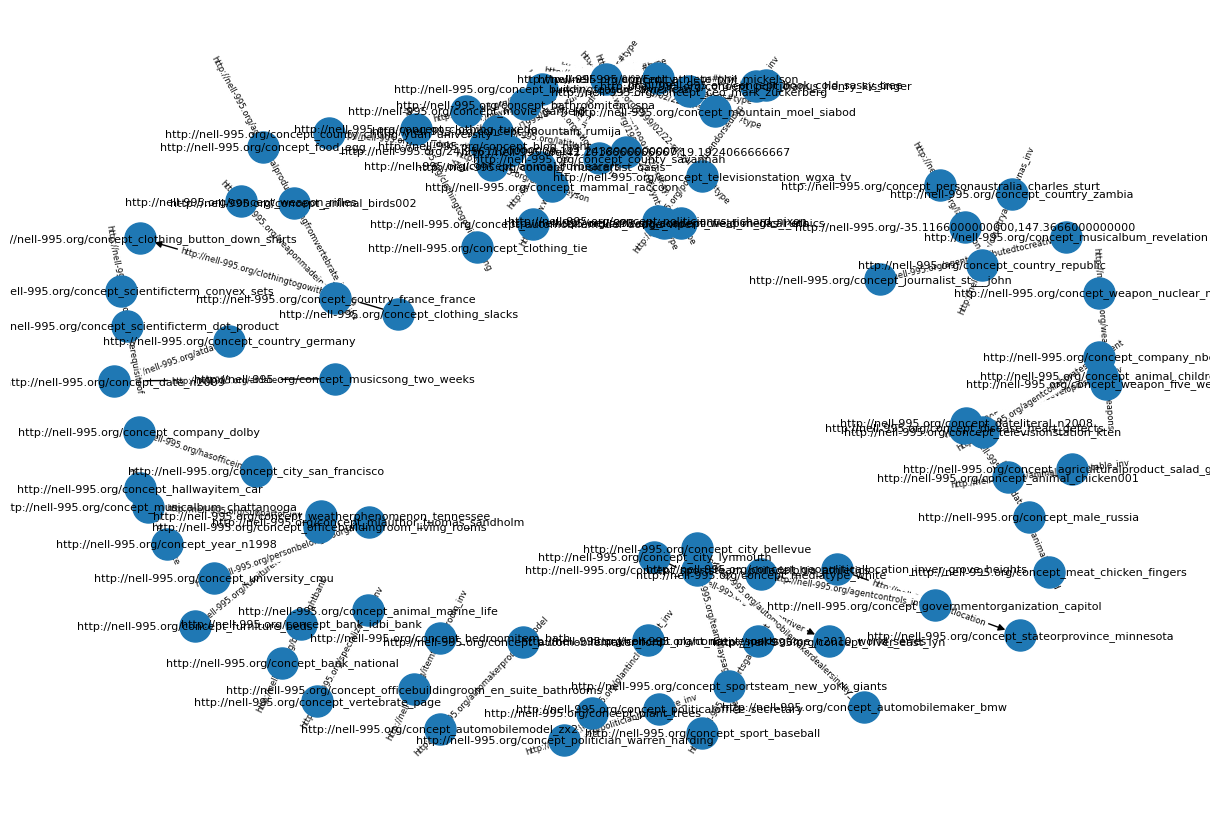

In [30]:
import networkx as nx
subgraph = list(g)[:50]  # 50 triplas
import matplotlib.pyplot as plt

# Converter o RDFLib Graph para NetworkX
G = nx.DiGraph()

for s, p, o in subgraph:
    G.add_edge(str(s), str(o), label=str(p))
    

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(s, o): p for s, o, p in G.edges(data='label')}, font_size=6)
plt.show()

In [38]:
import spacy
import re


nlp_en = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r"http\S+", "", text)       # URLs
    text = re.sub(r"@\w+", "", text)          # Menções
    text = re.sub(r"#\w+", "", text)          # Hashtags
    text = re.sub(r"[^A-Za-z0-9\s,.!?-]", "", text)  # Caracteres estranhos
    text = re.sub(r"\s+", " ", text)  # remove múltiplos espaços/newlines
    return text.strip()


def nlp_process(text):
    return nlp_en(text)

def entities(doc):
    entities = []

    for ent in doc.ents:
        entities.append({
            "text": ent.text,
            "type": ent.label_
        })

    return entities

def clean_tokens(doc):
    tokens = []

    for token in doc:
        if not token.is_stop and not token.is_punct:
            tokens.append(token.lemma_.lower())

    return tokens
def relations(doc):
    relations = []

    for token in doc:
        # Sujeito-VERBO-Objeto
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            subj = [c for c in token.children if c.dep_.startswith("nsubj")]
            obj = [c for c in token.children if c.dep_ in ("dobj", "pobj")]
            if subj and obj:
                rel = {
                    "subject": subj[0].text,
                    "relation": token.lemma_,
                    "object": obj[0].text
                }
                for child in obj[0].children:
                    if child.dep_ == "nummod":
                        rel["quantity"] = child.text
                relations.append(rel)

    return relations

def getnlp(text):
    cleaned = clean_text(text)
    doc = nlp_process(cleaned)

    return {
        "clean_text": cleaned,
        "tokens": clean_tokens(doc),
        "entities": entities(doc),
        "relations": relations(doc)
    }

article = """
    Cristiano Ronaldo scored 2 goals for Al Nassr yesterday in the match played in Riyadh.
    He is considered one of the best players in the world.
    """

result = getnlp(article)

print("\n==== Clean Text ====")
print(result["clean_text"])

print("\n==== Tokens ====")
print(result["tokens"])

print("\n==== Entities ====")
for e in result["entities"]:
    print(e)

print("\n==== Relations ====")
for r in result["relations"]:
    print(r)


==== Clean Text ====
Cristiano Ronaldo scored 2 goals for Al Nassr yesterday in the match played in Riyadh. He is considered one of the best players in the world.

==== Tokens ====
['cristiano', 'ronaldo', 'score', '2', 'goal', 'al', 'nassr', 'yesterday', 'match', 'play', 'riyadh', 'consider', 'good', 'player', 'world']

==== Entities ====
{'text': 'Cristiano Ronaldo', 'type': 'PERSON'}
{'text': '2', 'type': 'CARDINAL'}
{'text': 'Al Nassr', 'type': 'ORG'}
{'text': 'yesterday', 'type': 'DATE'}
{'text': 'Riyadh', 'type': 'GPE'}
{'text': 'one', 'type': 'CARDINAL'}

==== Relations ====
{'subject': 'Ronaldo', 'relation': 'score', 'object': 'goals', 'quantity': '2'}


Cristiano Ronaldo → http://nell-995.org/concept_athlete_cristiano_ronaldo
2 → None
Al Nassr → http://nell-995.org/concept_organization_al_eastern_division
yesterday → None
Riyadh → http://nell-995.org/concept_city_riyadh
one → None
